### Environment Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import requests
import math
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat

from bs4 import BeautifulSoup
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
df_movie = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/tmdb_5000_movies.csv')
df_movie.head()
df_movie.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
df_credit = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/tmdb_5000_credits.csv')
df_credit.head()
df_credit.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

### Data Preprocessing (1): Remove unwanted columns and rows

In [ ]:
''' calculate the number of missing row for each column '''
for column in df_movie.columns:
  print(sum(df_movie[column].isnull()))

''' remove unwanted columns ''' 
df_movie.drop(['homepage', 'id', 'original_title', 'popularity', 'keywords'], axis=1, inplace=True)

''' remove movies in status of post-production or rumored '''
#df_movie[df_movie['status'] != 'Released']
df_movie = df_movie[df_movie['status'] == 'Released']

''' remove movies with zero revenue '''
df_movie = df_movie[df_movie['revenue'] != 0]

''' web scrapping to recover missing data '''  
''' Website(1): omdb '''
# response = requests.get("http://www.omdbapi.com/?t=the+lover&apikey=e88b14b8")
# print(response.status_code)
# response.json()

''' Website(2): box office mojo by imdb '''  
# response = requests.get("https://www.boxofficemojo.com/search/?q=the+lover")
# BeautifulSoup(response, 'html.parser')

''' reset dataframe index '''
df_movie.reset_index(drop=True, inplace=True)

0
0
3091
0
0
0
0
3
0
0
0
1
0
2
0
0
844
0
0
0


### Data Preprocessing (2): Import preprocessed data for Json columns

In [ ]:
df_genres = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_genre.csv', index_col=0)
df_genres.drop('index', axis=0, inplace=True)

df_countries = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_countries.csv', index_col=0)
df_countries = df_countries.iloc[1:,:]

df_spoken_lang = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_spoken_lang.csv', index_col=0)
df_spoken_lang = df_spoken_lang.iloc[1:,:]

df_cast = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_cast.csv', index_col=0)
df_cast.head()

,Samuel L. Jackson,Robert De Niro,Matt Damon,Morgan Freeman,Bruce Willis,Johnny Depp,Owen Wilson,Brad Pitt,Liam Neeson,Nicolas Cage,Willem Dafoe,Steve Buscemi,Stanley Tucci,Tom Cruise,Bill Murray,Ben Stiller,Alec Baldwin,Tom Hanks,Harrison Ford,Arnold Schwarzenegger,Will Ferrell,George Clooney,Cameron Diaz,John Goodman,Sylvester Stallone,Justin Long,J.K. Simmons,Frank Welker,Jack Black,Bill Hader,Paul Giamatti,Ben Affleck,Mark Wahlberg,Seth Rogen,Ben Kingsley,Antonio Banderas,Denzel Washington,Christopher Walken,Woody Harrelson,Cate Blanchett,...,Ryan Reynolds,Dennis Quaid,Mel Gibson,Danny DeVito,Queen Latifah,Salma Hayek,Scarlett Johansson,Danny Trejo,John Malkovich,Bruce Greenwood,Bruce McGill,Allison Janney,Robert Patrick,John Cusack,Steve Carell,Angelina Jolie,Sandra Bullock,Dan Aykroyd,Judi Dench,James Cromwell,Ed Harris,Josh Brolin,Paul Bettany,Gene Hackman,Kevin Spacey,Anne Hathaway,Anna Faris,Gwyneth Paltrow,Kirsten Dunst,Don Cheadle,Bill Paxton,Sean Bean,Catherine Keener,Alan Tudyk,Jeffrey Wright,Michael Peña,Kathy Bates,Jane Lynch,John Ratzenberger,Pierce Brosnan
Avatar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Spectre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
John Carter,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Preprocessing (3): Merge df_movie and df_credit

In [ ]:
df_movie = df_movie.merge(df_credit, how='left', on='title', copy=False) # len(df_movie) = 3378

''' check for duplicated rows in title '''
#duplicate = df_movie[df_movie.duplicated(subset='title')] 
#df_movie[df_movie['title']=='Batman']
#df_movie[df_movie['title']=='The Host']
df_movie.drop([925, 1259, 2433], axis=0, inplace=True)
df_movie.reset_index(drop=True, inplace=True)

### Data Preprocessing (4): Sentiment Analysis
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

In [ ]:
from textblob import TextBlob
import re
import scipy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
''' movie review from IMDB data '''
reviews_train = []
for line in open('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/full_train.txt', 'r'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/full_test.txt', 'r'):
    reviews_test.append(line.strip())

In [ ]:
''' text cleaning ''' 
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [ ]:
''' Vectorization: convert each review to a numeric representation '''
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)
train = scipy.sparse.vstack([X, X_test])

In [ ]:
''' Model 1: Logistic Regression'''
target = (([1]*12499 + [0]*12501)*2) #the first 12.5k are positive and the last 12.5k are negative
final_model = LogisticRegression(C=0.05)
final_model.fit(train, target)

''' Prediction '''
test = cv.transform(df_movie['overview'].values.tolist())
result = final_model.predict(test)

''' Model 2: Multinomial Naive Bayes '''
clf = MultinomialNB()
clf.fit(train, target)
result_1 = clf.predict(test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
df_movie['sentiment'] = result
df_movie['sentiment_1'] = result_1 

### Data Preprocessing (5): One Hot Encoding


In [ ]:
''' original_language '''
df_lang = pd.get_dummies(df_movie.loc[:,'original_language'])
df_lang.head()

,af,cn,da,de,el,en,es,fa,fr,he,hi,id,is,it,ja,ko,nb,nl,no,pl,pt,ro,ru,te,th,vi,xx,zh
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
''' release date '''
df_movie['month'] = df_movie['release_date'].str[5:7]
df_month = pd.get_dummies(df_movie.loc[:, 'month'])
df_month

,01,02,03,04,05,06,07,08,09,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3370,0,0,0,0,0,0,0,0,1,0,0,0
3371,0,0,1,0,0,0,0,0,0,0,0,0
3372,0,0,0,0,0,0,0,0,0,0,1,0
3373,0,0,0,0,0,0,0,0,0,1,0,0


### Explanatory Data Analysis

In [ ]:
plt.style.use('bmh')
mat.rcParams['axes.titlesize'] = 15

In [ ]:
''' budget '''
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(np.log(df_movie['budget']), np.log(df_movie['revenue']), c='white')
ax.set_title('Budget in US dollar', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Budget')
ax.set_ylabel('Revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
#ax.xaxis.set_ticks(np.arange(2001,2018,2))
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_budget.png',
            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
''' runtime '''
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(df_movie['runtime'], np.log(df_movie['revenue']), c='white')
ax.set_title('Runtime in minutes', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Runtime')
ax.set_ylabel('Revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
#ax.xaxis.set_ticks(np.arange(2001,2018,2))
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_runtime.png',
            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
''' counts by month '''
fig = plt.figure()
ax = fig.add_subplot(111)

sns.countplot(x="month", data=df_movie)
ax.set_title('No. of movies by months', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Months')
ax.set_ylabel('Counts')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.set_xticklabels(labels = [('0'+str(i)) for i in range(1,10)] + ['10', '11', '12'])
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_bar_month.png',
            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
''' months with 'Avatar '''
fig = plt.figure()
ax = fig.add_subplot(111)

flierprops = dict(markerfacecolor='white', markeredgecolor='w')
sns.boxplot(x="month", y='revenue'), data=df_movie.drop(0), flierprops=flierprops)
ax.set_title('Revenue by months', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Months')
ax.set_ylabel('Revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.set_xticklabels(labels = [('0'+str(i)) for i in range(1,10)] + ['10', '11', '12'])
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

#plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_box_month.png',
#            dpi=2000, bbox_inches='tight',transparent=True)

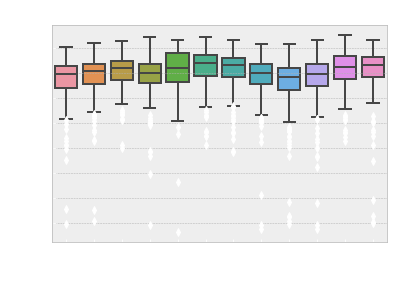

In [ ]:
''' months after dropping avatar'''
fig = plt.figure()
ax = fig.add_subplot(111)

flierprops = dict(markerfacecolor='white', markeredgecolor='w')
sns.boxplot(x="month", y='revenue'), data=df_movie.drop(0), flierprops=flierprops)
ax.set_title('Revenue by months', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Months')
ax.set_ylabel('Revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.set_xticklabels(labels = [('0'+str(i)) for i in range(1,10)] + ['10', '11', '12'])
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

#plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_box_month.png',
#            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
''' months '''
fig = plt.figure()
ax = fig.add_subplot(111)

flierprops = dict(markerfacecolor='white', markeredgecolor='w')
sns.boxplot(x="month", y=np.log(df_movie['revenue']), data=df_movie, flierprops=flierprops)
ax.set_title('Revenue by months', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Months')
ax.set_ylabel('Revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.set_xticklabels(labels = [('0'+str(i)) for i in range(1,10)] + ['10', '11', '12'])
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_box_month.png',
            dpi=2000, bbox_inches='tight',transparent=True)

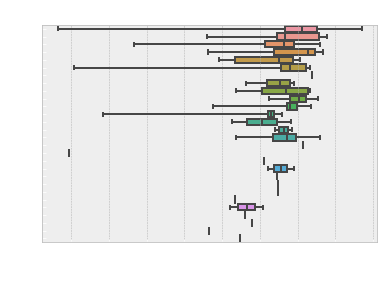

In [ ]:
''' original languages '''
fig = plt.figure()
ax = fig.add_subplot(111)

flierprops = dict(markerfacecolor='white', markeredgecolor='w')
sns.boxplot(y="original_language", x=np.log(df_movie['revenue']), 
            data=df_movie, flierprops=flierprops, whis="range")
ax.set_title('Revenue by languages', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')

ax.set_xlabel('Revenue')
ax.set_ylabel('Languages')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/plot_box_language.png',
            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
df_movie.columns

Index(['budget', 'genres', 'original_language', 'overview',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'month'],
      dtype='object')

### Model Selection & Result

In [ ]:
!pip install graphviz 
from xgboost import XGBRegressor, plot_tree
from sklearn.metrics import r2_score

In [ ]:
df_genres.reset_index(inplace=True)
df_countries.reset_index(inplace=True)
df_spoken_lang.reset_index(inplace=True)
df_cast.reset_index(inplace=True)

In [ ]:
''' Features 1-4: budget, runtime, sentiment, sentiment_1 '''
x = df_movie.loc[:, ['budget', 'runtime', 'sentiment', 
                     'sentiment_1', 'title']]

''' Feature 5: genres '''
x = x.merge(df_genres, how='left', left_on='title', right_on='index', copy=False)

''' Feature 6: original languages '''
x = pd.concat([x,df_lang], axis=1)

''' Feature 7: production_countries '''
x = x.merge(df_countries, how='left', left_on='title', right_on='index', copy=False)

''' Feature 8: release_month '''
x = pd.concat([x,df_month], axis=1)

''' Feature 9: spoken_languages'''
x = x.merge(df_spoken_lang, how='left', left_on='title', right_on='index', copy=False)

''' Feature 10: cast '''
x = x.merge(df_cast, how='left', left_on='title', right_on='index', copy=False)
x.drop(['index_x', 'index_y', 'title'], axis=1, inplace=True)

y = df_movie['revenue']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

model = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 4, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')

#model = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 4, min_child_weight= 5,
#                         subsample = 0.8, objective='reg:squaredlogerror')

model.fit(x, y)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
score

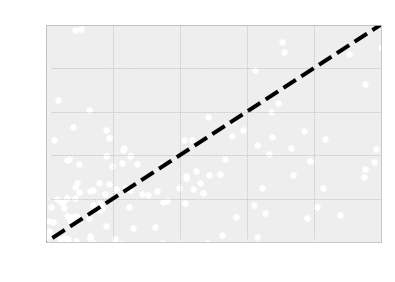

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, y_pred, c='w')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

ax.set_title('Measured VS Predicted Revenue', fontdict={'fontsize': mat.rcParams['axes.titlesize']}, color='white')
plt.ylim((50000000, 300000000))   
plt.xlim(50000000, 300000000)     

ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')

ax.xaxis.label.set_color('white')
ax.xaxis.label.set_fontsize('15')
ax.tick_params(axis='x', colors='white')

ax.yaxis.label.set_color('white')
ax.yaxis.label.set_fontsize('15')
ax.tick_params(axis='y', colors='white')

plt.savefig('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/regression.png',
            dpi=2000, bbox_inches='tight',transparent=True)

In [ ]:
x_names = x.columns.values 
importances = {}
count = 0
for feature_importance in model.feature_importances_:
    if feature_importance > 0.002:
        feature_name = x_names[count]
        importances[feature_name] = feature_importance
    count+=1
    
import operator
sorted_importances = sorted(importances.items(), key=operator.itemgetter(1), reverse=True)
sorted_importances

In [ ]:
''' Top Countries ''''
top_countries = []
for i in df_countries.columns: 
  for j in sorted_importances:
    if i in j:
      top_countries.append(j)

top_countries = dict(top_countries)
sorted(top_countries.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
''' Top Genres '''
top_genres = []
for i in df_genres.columns:
  for j in sorted_importances:
    if i in j:
      top_genres.append(j)
top_genres = dict(top_genres)
sorted(top_genres.items(), key=operator.itemgetter(1), reverse=True)

[('Adventure', 0.04538076),
 ('Animation', 0.028704138),
 ('Drama', 0.0254114),
 ('Fantasy', 0.021728968),
 ('Family', 0.012634701),
 ('Science Fiction', 0.009430252),
 ('War', 0.0089692585),
 ('Western', 0.008828192),
 ('History', 0.007590248),
 ('Thriller', 0.0068058423),
 ('Action', 0.004516705),
 ('Romance', 0.0034103033),
 ('Comedy', 0.002627116),
 ('Crime', 0.0026083502),
 ('Horror', 0.002128222)]

In [ ]:
''' Top Language '''
top_lang = []
for i in df_lang.columns:
  for j in sorted_importances:
    if i in j:
      top_lang.append(j)
top_lang = dict(top_lang)
sorted(top_lang.items(), key=operator.itemgetter(1), reverse=True)

[('en', 0.020950291)]

In [ ]:
''' Top spoken Language '''
top_spoken_lang = []
for i in df_spoken_lang.columns:
  for j in sorted_importances:
    if i in j:
      top_spoken_lang.append(j)
top_spoken_lang = dict(top_spoken_lang)
sorted(top_spoken_lang.items(), key=operator.itemgetter(1), reverse=True)

[('Deutsch', 0.016492184),
 ('Español', 0.0144747645),
 ('svenska', 0.008002615),
 ('Pусский', 0.007924542),
 ('Français', 0.006309815),
 ('Italiano', 0.0059972126),
 ('ภาษาไทย', 0.0046043484),
 ('ελληνικά', 0.0037860116),
 ('Latin', 0.0037249378),
 ('日本語', 0.002256548),
 ('Norsk', 0.0020025868)]

In [ ]:
''' Does sentiment matter? '''
for i in sorted_importances:
  if 'sentiment' in i:
    print(i)

('sentiment', 0.0021437833)


In [ ]:
''' Does runtime matter? '''
for i in sorted_importances:
  if 'runtime' in i:
    print(i)

('runtime', 0.013577174)


In [ ]:
''' Actors '''
top_cast = []
for i in df_cast:
  for j in sorted_importances:
    if i in j:
      top_cast.append(j)
top_cast = dict(top_cast)
sorted(top_cast.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
''' Linear Regression'''
x = x.fillna(0)
model_1 = LinearRegression()
model_1.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
''' Regression coefficients ''' 
coef = {}
for i in range(len(x.columns)):
  coef[x.columns[i]] = model_1.coef_[i]
coef 

sorted_coef = sorted(coef.items(), key=operator.itemgetter(1), reverse=True)
sorted_coef

### Appendix (1): Deal with Json columns in df_movie

In [ ]:
''' Deal with 'genres' column ''' 
def json_to_df(column):
  df = pd.DataFrame()

  for i in range(len(df_movie)):
    ''' convert column content into dict '''
    json_string = df_movie.loc[i,column]   
    json_dict = json.loads(json_string)   

    ''' create a df from dict '''
    temp = pd.DataFrame.from_dict(json_dict)
    temp['movie'] = df_movie.loc[i, 'title']

    '''  reshape df using pivot '''
    temp['index']  = temp.groupby('movie').cumcount()
    temp = temp.pivot(index='movie', columns='index')  

    ''' concat all dfs into one df '''
    df = pd.concat([df, temp])
  
  return df

In [ ]:
''' 
json columns:  'genres', 'production_companies', 'production_countries', 'spoken_languages'
'''
df_genres = json_to_df('genres')

''' two rows with duplicate index name 'The Host' '''
df_genres.index = df_genres.index.where(~df_genres.index.duplicated(), df_genres.index + '_1')

''' one missing row '''
# set.difference(set(df_movie['title']), set(df_genres.index))
# df_movie[df_movie['title'] == 'The Book of Mormon Movie, Volume 1: The Journey']
temp =  pd.DataFrame(data=[], index=['The Book of Mormon Movie, Volume 1: The Journey'])
df_genres = pd.concat([df_genres, temp])

''' Create a dict with movies as keys and genres as values '''
movie_genres = dict()
for index in df_genres.index:
  for name in df_genres['name'].columns:
    if (type(df_genres['name'][name][index]) == str):
      try:
        movie_genres[index].append(df_genres['name'][name][index])
      except:
        movie_genres[index] = [df_genres['name'][name][index]]
    else: 
      try:
        movie_genres[index].append('')
      except:
        movie_genres[index] = ['']

''' Find out all types of genres '''
genres = []
for i in df_genres['name'].columns:
  genres.extend(df_genres['name'][i].unique())

genres = set(genres)
genres = {x for x in genres if x==x} # remove nan from the genre set

''' create dummy variable for each genres '''
for genre in genres:
  temp = []
  for movie in movie_genres.keys():
    if genre in movie_genres[movie]:
      temp.append(1) 
    else:
      temp.append(0)
  df_genres[genre] = temp

''' keep only dummy columns '''
df_genres.drop(columns= df_genres.columns[0:14], inplace=True)
#df_genres.to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_genre.csv')

In [ ]:
''' production_companies '''
df_companies = json_to_df('production_companies')

''' Create a dict with movies as keys and companies as values '''
movie_companies = dict()
for index in df_companies.index:
  for name in df_companies['name'].columns:
    if (type(df_companies['name'][name][index]) == str):
      try:
        movie_companies[index].append(df_companies['name'][name][index])
      except:
        movie_companies[index] = [df_companies['name'][name][index]]
    else: 
      try:
        movie_companies[index].append('')
      except:
        movie_companies[index] = ['']

''' Find out all types of companies '''
companies = []
for i in df_companies['name'].columns:
  companies.extend(df_companies['name'][i].unique())
companies = set(companies)
companies = {x for x in companies if x==x} # remove nan from the genre set

''' create dummy variable for each companies'''
for companies in companies:
  temp = []
  for movie in movie_companies.keys():
    if companies in movie_companies[movie]:
      temp.append(1) 
    else:
      temp.append(0)
  df_companies[companies] = temp

df_companies.head()

In [ ]:
''' production_countries '''
df_countries = json_to_df('production_countries')

''' two rows with duplicate index name 'The Host' '''
df_countries.index = df_countries.index.where(~df_countries.index.duplicated(), df_countries.index + '_1')

''' a movies list with missing countries data '''
missing_countries = list(set.difference(set(df_movie['title']), set(df_countries.index)))

''' build a search list for OMDB api '''
search_list = []
for countries in missing_countries:
  temp = countries.split(' ')
  result = ''
  for words in temp:
    result += '+' + words
  search_list.append(result[1:])

''' get data from OMBD data '''
temp = []
for movies in search_list:
  url = "http://www.omdbapi.com/?t=" + movies + "&apikey=e88b14b8"
  response = requests.get(url)
  temp.append(response.json())

df = pd.DataFrame()
for i in temp:
  key = i['Title']
  value = i['Country']
  temp_df = pd.DataFrame(data=[value], index=[key], columns=[('name',0)])
  df = pd.concat([df, temp_df])

''' correct data for a faulty search: Town & Country '''
df.drop('The Town That Dreaded Sundown', axis=0, inplace=True)  # remove the wrong result 
t_c = pd.DataFrame(data=['USA'], index=['Town & Country'], columns=[('name',0)]) # insert the correct result manually
df = pd.concat([df,t_c])

df[('name'),1] = None
df.loc['The Last Godfather', ('name',0)] = 'USA'
df.loc['The Last Godfather', ('name',1)] = 'South Korea'
df.loc['Sheena', ('name',0)] = 'USA'
df.loc['Sheena', ('name',1)] = 'UK'

countries_map = {'USA':'United States of America', 'UK':'United Kingdom',
                 'India':'India', 'China':'China', 'Australia':'Australia',
                 'South Korea':'South Korea'}
df[('name', 0)] = df[('name', 0)].map(countries_map)
df[('name', 1)] = df[('name', 1)].map(countries_map)

df_countries = pd.concat([df_countries, df])

''' Create a dict with movies as keys and countries as values '''
movie_countries = dict()
for index in df_countries.index:
  for name in df_countries['name'].columns:
    if (type(df_countries['name'][name][index]) == str):
      try:
        movie_countries[index].append(df_countries['name'][name][index])
      except:
        movie_countries[index] = [df_countries['name'][name][index]]
    else: 
      try:
        movie_countries[index].append('')
      except:
        movie_countries[index] = ['']

''' Find out all types of countries '''
countries = []
for i in df_countries['name'].columns:
  countries.extend(df_countries['name'][i].unique())
countries = set(countries)
countries = {x for x in countries if x==x} # remove nan from the genre set

''' create dummy variable for each country '''
for country in countries:
  temp = []
  for movie in movie_countries.keys():
    if country in movie_countries[movie]:
      temp.append(1) 
    else:
      temp.append(0)
  df_countries[country] = temp

''' keep only dummy columns '''
df_countries.drop(columns= df_countries.columns[0:24], inplace=True)
#df_countries.to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_countries.csv')

In [ ]:
''' spoken_languages '''
df_spoken_lang = json_to_df('spoken_languages')

''' two rows with duplicate index name 'The Host' '''
df_spoken_lang.index = df_spoken_lang.index.where(~df_spoken_lang.index.duplicated(), df_spoken_lang.index + '_1')

''' a movies list with missing spoken languages data '''
missing_lang = list(set.difference(set(df_movie['title']), set(df_spoken_lang.index)))
# len(missing_lang) == 10

''' build a search list for OMDB api '''
search_list = []

for movie in missing_lang:
  temp = movie.split(' ')
  result = ''
  for words in temp:
    result += '+' + words
  search_list.append(result[1:])

''' get data from OMBD data '''
temp = []
for movies in search_list:
  url = "http://www.omdbapi.com/?t=" + movies + "&apikey=e88b14b8"
  response = requests.get(url)
  temp.append(response.json())

df = pd.DataFrame()
for i in temp:
  key = i['Title']
  value = i['Language']
  temp_df = pd.DataFrame(data=[value], index=[key], columns=[('name',0)])
  df = pd.concat([df, temp_df])

''' The Big Parade is a silent film '''
df.loc['The Big Parade', ('name',0)] = 'No Language'

df[('name',1)] = None
df.loc['The Basket', ('name',0)] = 'English'
df.loc['The Basket', ('name',1)] = 'Deutsch'

df_spoken_lang = pd.concat([df_spoken_lang, df])
 
 ''' Create a dict with movies as keys and spoken_languages as values '''
movie_languages = dict()
for index in df_spoken_lang.index:
  for name in df_spoken_lang['name'].columns:
    if (type(df_spoken_lang['name'][name][index]) == str):
      try:
        movie_languages[index].append(df_spoken_lang['name'][name][index])
      except:
        movie_languages[index] = [df_spoken_lang['name'][name][index]]
    else: 
      try:
        movie_languages[index].append('')
      except:
        movie_languages[index] = ['']

''' Find out all types of spoken_lang '''
spoken_lang = []
for i in df_spoken_lang['name'].columns:
  spoken_lang.extend(df_spoken_lang['name'][i].unique())
spoken_lang = set(spoken_lang)
spoken_lang = {x for x in spoken_lang if x==x} # remove nan from the genre set
spoken_lang.remove('')
spoken_lang.remove(None)

''' create dummy variable for each spoken_lang '''
for language in spoken_lang:
  temp = []
  for movie in movie_languages.keys():
    if language in movie_languages[movie]:
      temp.append(1) 
    else:
      temp.append(0)
  df_spoken_lang[language] = temp

''' keep only dummy columns '''
df_spoken_lang.drop(columns= df_spoken_lang.columns[0:18], inplace=True)
#df_spoken_lang.to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_spoken_lang.csv')

### Appendix (2): Deal with 'cast' column in df_credit

In [ ]:
''' df_credit's cast column '''
df_cast = json_to_df('cast')

''' two rows with duplicate index name 'The Host' '''
df_cast.index = df_cast.index.where(~df_cast.index.duplicated(), df_cast.index + '_1')

''' two missing row '''
# set.difference(set(df_movie['title']), set(df_cast.index))
# df_movie[df_movie['title'] == "2016: Obama's America"]
# df_movie[df_movie['title'] == 'Ayurveda: Art of Being']

temp =  pd.DataFrame(data=[], index=["2016: Obama's America"])
df_cast = pd.concat([df_cast, temp])

temp =  pd.DataFrame(data=[], index=['Ayurveda: Art of Being'])
df_cast = pd.concat([df_cast, temp])

#df_cast.to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_cast_initial.csv')

In [ ]:
df_cast = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_cast_initial.csv', index_col=0)
df_cast = df_cast.iloc[1:, :]
df_cast.head()

In [ ]:
''' Find out all cast and find out top 150 cast'''
cast = []
for i in df_cast.columns[1120:1344]:
  cast.extend(df_cast[i])
cast

from collections import Counter
actor_count = Counter(cast)
sorted_actor = sorted(actor_count.items(), key=operator.itemgetter(1), reverse=True)
#pd.DataFrame(sorted_actor).to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/cast_count.csv')

In [ ]:
sorted_actor = pd.read_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/cast_count.csv', index_col=0)
sorted_actor.iloc[1:20]

In [ ]:
''' Create a dict with movies as keys and cast as values '''
movie_cast = dict()
for index in df_cast.index:
  for name in df_cast.columns[1120:1343]:
    if (type(df_cast[name][index]) == str):
      try:
        movie_cast[index].append(df_cast[name][index])
      except:
        movie_cast[index] = [df_cast[name][index]]
    else: 
      try:
        movie_cast[index].append('')
      except:
        movie_cast[index] = ['']
movie_cast

In [ ]:
cast = sorted_actor['0'][1:151].tolist()

''' create dummy variable for each genres '''
for cast in cast:
  temp = []
  for movie in movie_cast.keys():
    if cast in movie_cast[movie]:
      temp.append(1) 
    else:
      temp.append(0)
  df_cast[cast] = temp

''' keep only dummy columns '''
df_cast.drop(columns= df_cast.columns[0:1568], inplace=True)
#df_genres.to_csv('/content/drive/My Drive/108-1 Intro to Data Analysis/Final/df_genre.csv')